# Generating SLiM exome recombination maps

This notebook generates a recombination map for SLiM that implements a realistic exome structure and includes the positions of sites from the archaic admixture array. It also saves the positions of array sites and coordinates of exons separately.

In [1]:
from pybedtools import BedTool
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
RECOMB_RATE = 1e-8 # crossovers per bp per generation

## Exon coordinates processing

First download the GTF annotations:

In [4]:
gtf = pd.read_table('ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/Homo_sapiens.GRCh37.75.gtf.gz',
                    header=None, sep='\t', skipinitialspace=True, skiprows=5, compression='gzip',
                    names=['chrom', 'source', 'feature', 'start', 'end',
                           'score', 'strand', 'frame', 'attribute'], low_memory=False)

What does the data look like?

In [5]:
gtf.head()

,chrom,source,feature,start,end,score,strand,frame,attribute
0,1,pseudogene,gene,11869,14412,.,+,.,"gene_id ""ENSG00000223972""; gene_name ""DDX11L1""..."
1,1,processed_transcript,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
2,1,processed_transcript,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
3,1,processed_transcript,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
4,1,processed_transcript,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."


In [6]:
gtf.source.value_counts()

protein_coding                        2001054
nonsense_mediated_decay                293471
processed_transcript                   173401
retained_intron                        150034
lincRNA                                 55928
antisense                               45811
processed_pseudogene                    24517
pseudogene                              17830
unprocessed_pseudogene                  13763
miRNA                                   10209
transcribed_unprocessed_pseudogene       7931
misc_RNA                                 6554
snRNA                                    6215
snoRNA                                   4791
sense_intronic                           3241
polymorphic_pseudogene                   1906
rRNA                                     1706
unitary_pseudogene                       1467
sense_overlapping                        1463
IG_V_gene                                1277
transcribed_processed_pseudogene         1182
non_stop_decay                    

In [7]:
gtf.feature.value_counts()

exon              1306656
CDS                791856
UTR                304070
transcript         215170
stop_codon          73411
start_codon         73358
gene                63677
Selenocysteine        114
Name: feature, dtype: int64

Take only autosomal protein-coding regions, since we won't be simulating sex chromosomes:

In [8]:
AUTOSOMES = [str(i + 1) for i in range(22)]

In [9]:
exons = gtf[gtf.chrom.isin(AUTOSOMES) &
           (gtf.source == "protein_coding") &
           (gtf.feature == "exon")]

Merge the overlapping exons:

In [10]:
exons = BedTool.from_dataframe(exons).sort().merge().to_dataframe()

In [11]:
exons['type'] = 'exon'

Convert chromosome IDs to integers and sort coordinates:

In [12]:
exons.chrom = exons.chrom.astype(int)
exons.sort_values(by=['chrom', 'start'], inplace=True)

What is the distribution of exon lengths?

In [13]:
lengths = exons.end - exons.start

In [14]:
lengths.describe()

count    214193.000000
mean        337.708039
std         776.506070
min           1.000000
25%          96.000000
50%         138.000000
75%         217.000000
max       24409.000000
dtype: float64

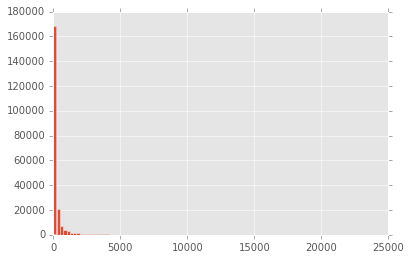

In [15]:
plt.figure_ = plt.hist(lengths, bins=100)

Filter out some very small exons:

In [16]:
exons = exons[lengths > 10]

Specify the recombination rate within exons:

In [17]:
exons.ix[exons.type == 'exon', 'recomb_rate'] = RECOMB_RATE

The modified dataframe:

In [18]:
exons.head()

,chrom,start,end,type,recomb_rate
0,1,69090,70008,exon,1.000000e-08
1,1,134900,135802,exon,1.000000e-08
2,1,137620,139379,exon,1.000000e-08
3,1,367639,368634,exon,1.000000e-08
4,1,621058,622053,exon,1.000000e-08


## Process positions from the archaic admixture array

Load the coordinates of sites from the archaic admixture array:

In [19]:
array_sites = pd.read_table('../raw_data/ice_age/filter.gz', names=['chrom', 'end', 'set_1', 'set_2'])

Subset to sites in the so called "Set 1" (see `raw_data/ice_age/README.md` for more information):

In [20]:
array_sites = array_sites[array_sites.set_1 == 1]

In [21]:
array_sites['start'] = array_sites.end - 1
array_sites = array_sites[['chrom', 'start', 'end']]

In [22]:
array_sites['type'] = 'snp'

DataFrame after filtering:

In [23]:
array_sites.head()

,chrom,start,end,type
0,1,847982,847983,snp
1,1,853088,853089,snp
2,1,853595,853596,snp
3,1,854792,854793,snp
5,1,867150,867151,snp


## Create a union of exon regions with admixture array informative positions

Inter-exon informative sites will be simulated individually, with an appropriate recombination rate set between them and adjacent exons or other informative sites. Intra-exon sites will be ignored when building the recombination map (they will be recombining as a part of the exons).

Take the subset of array sites that lie outside exons:

In [24]:
exome = BedTool.from_dataframe(exons)
sites_outside_exons = BedTool.from_dataframe(array_sites).intersect(exome, v=True).to_dataframe().rename(columns={'name': 'type'})

In [25]:
exons_and_sites = pd.concat([sites_outside_exons,
                             exons]).sort_values(by=['chrom', 'start']).reset_index(drop=True)
exons_and_sites = exons_and_sites[['chrom', 'start', 'end', 'type', 'recomb_rate']]

In [26]:
exons_and_sites.head()

,chrom,start,end,type,recomb_rate
0,1,69090,70008,exon,1.000000e-08
1,1,134900,135802,exon,1.000000e-08
2,1,137620,139379,exon,1.000000e-08
3,1,367639,368634,exon,1.000000e-08
4,1,621058,622053,exon,1.000000e-08


In [27]:
len(exons_and_sites)

978504

## Generating the recombination map of exons and archaic admixture array sites

In [28]:
def add_recombination_gaps(regions):
    """Add 1 bp "recombination gap" between each record in
    a given DataFrame of exon and snp coordinates.
    """
    # create a new DataFrame with coordinates of 1 bp gaps
    gaps = pd.DataFrame({'chrom'       : regions.chrom.values,
                         'start'       : regions.end.values,
                         'end'         : regions.end.values + 1,
                         'recomb_rate' : list(RECOMB_RATE * (regions.start[1:].values -  # between exons/sites
                                                             regions.end[:-1].values)) +
                                         [0.5], # between chromosomes
                         'type'        : 'gap'},
                        columns=['chrom', 'start', 'end', 'recomb_rate', 'type'])

    # merge the dataframes of regions and gap coordinates
    regions_and_gaps = pd.concat([regions, gaps]).sort_values(by=['chrom', 'start']).reset_index(drop=True)

    return regions_and_gaps[['chrom', 'start', 'end', 'type', 'recomb_rate']]


def concatenate_regions(regions):
    """Concatenate regions/sites on all chromosome as if they were
    directly adjacent on a single chromosome, changing the coordinates
    accordingly.
    """
    concat_regions = regions.copy()

    concat_regions['width'] = regions.end - regions.start
    concat_regions['slim_start'] = pd.Series([0] + list(concat_regions.width[:-1])).cumsum()
    concat_regions['slim_end'] = concat_regions.width.cumsum() - 1
    
    return concat_regions


def create_recomb_map(regions):
    """Create recombination map for all regions/sites on all chromosomes."""
    recomb_map = []

    for chrom in AUTOSOMES:
        # add recombination gaps between regions on this chromosome
        recomb_map.append(add_recombination_gaps(regions.query('chrom == {}'.format(chrom))))
        
    # concatenate exome recombination maps of all chromosomes
    recomb_map = pd.concat(recomb_map, ignore_index=True).sort_values(by=['chrom', 'start']).reset_index(drop=True)

    # remove the very last base of the recombination map
    # (it has a 0.5 recombination rate anyway and there's no other chromosome
    # after it)
    recomb_map = recomb_map[:-1]
    
    return recomb_map

Recombination rate between exons and/or informative positions is implemented by inserting a 1 bp "gap" between each adjacent region/site and setting the recombination rate at these positions to $L \times 1\cdot10^{-8}$ crossovers per generation ($L$ is the distance between exons/sites).

The recombination rate of the "gap" between the last feature on one chromosome and the first feature on another chromosome will be 0.5.

Create a recombination map of exons and informative sites. Inserts 1bp recombination gaps between each region and site and between different chromosomes:

In [29]:
recomb_map = create_recomb_map(exons_and_sites)

In [30]:
recomb_map.head()

,chrom,start,end,type,recomb_rate
0,1,69090,70008,exon,1.000000e-08
1,1,70008,70009,gap,6.489200e-04
2,1,134900,135802,exon,1.000000e-08
3,1,135802,135803,gap,1.818000e-05
4,1,137620,139379,exon,1.000000e-08


Convert the coordinates of all regions/sites/gaps into SLiM's 0-based single segment coordinate system:

In [31]:
concat_map = concatenate_regions(recomb_map)

In [32]:
concat_map.head()

,chrom,start,end,type,recomb_rate,width,slim_start,slim_end
0,1,69090,70008,exon,1.000000e-08,918,0,917
1,1,70008,70009,gap,6.489200e-04,1,918,918
2,1,134900,135802,exon,1.000000e-08,902,919,1820
3,1,135802,135803,gap,1.818000e-05,1,1821,1821
4,1,137620,139379,exon,1.000000e-08,1759,1822,3580


Save the recombination map in a SLiM-friendly format (end-positions of exons and gaps, without the positions of SNPs since they don't have recombination rates themselves):

In [33]:
concat_map.query('type != "snp"')[['slim_end', 'recomb_rate']].to_csv('../slim/recombination_map.txt', sep='\t', index=False)

## Save SLiM coordinates of all sites from the archaic admixture array

Recombination map includes only positions of sites that fall outside of exonic regions. However, in order to simulate the sites from the archaic admixture array, we have to know the positions of sites _within_ exons too.

SLiM simulates all exons and individual sites as one continuous segment of concatenated regions, with coordinates of exons and sites shifted appropriately. To obtain the coordinates of array sites within exons, we need to find out, for each site, which exon does it fall in and calculate its position relative to the start of that exon.

Take the subset of array sites that lie inside exons:

In [34]:
sites_within_exons = BedTool.from_dataframe(array_sites).intersect(exome).to_dataframe()

In [35]:
sites_within_exons = sites_within_exons.rename(columns={'name': 'type'})

Get a DataFrame of the coordinates of exons that contain a site from the admixture array (will contain multiple copies of one exon if more than one site falls within that exon):

In [36]:
exons_with_sites = BedTool.from_dataframe(concat_map.query('type == "exon"')).intersect(BedTool.from_dataframe(sites_within_exons), wa=True).to_dataframe()


# rename and subset columns
exons_with_sites = exons_with_sites.rename(columns={'name': 'type',
                                                    'score': 'recomb_rate',
                                                    'strand': 'width',
                                                    'thickStart': 'slim_start',
                                                    'thickEnd': 'slim_end'})[['chrom', 'start', 'end', 'type', 'recomb_rate', 'width', 'slim_start', 'slim_end']]

Calculate the position of each site relative to the start of "its" exon and convert this position into a SLiM single-segment coordinate (i.e. relative the the position 0 of the simulated segment):

In [37]:
sites_within_exons['width'] = 1
sites_within_exons['slim_start'] = sites_within_exons.start - exons_with_sites.start + exons_with_sites.slim_start
sites_within_exons['slim_end'] = sites_within_exons.slim_start

Merge the coordinates of SNPs within and outside exons:

In [38]:
all_sites = pd.concat([sites_within_exons, concat_map.query('type == "snp"')]).sort_values(by=['slim_start']).reset_index(drop=True)

Verify that we didn't loose any sites during all this coordinate acrobatics:

In [39]:
len(array_sites) == len(all_sites)

True

Output the SLiM-based positions of informative sites:

In [40]:
all_sites['slim_start'].to_csv('../slim/admixture_array_coordinates.txt', index=False)

## Save SLiM coordinates of exonic regions only

This is required for specification for the `initializeGenomicElement` function in SLiM.

In [41]:
concat_map.query('type == "exon"')[['slim_start', 'slim_end']].to_csv('../slim/exon_coordinates.txt', sep='\t', index=False)

<br><br><br><br><br>
# Testing of the recombination map building functions

Sample 5 exons/sites for each chromosome to make a testing data set.

In [42]:
test_data = exons_and_sites.groupby('chrom') \
                           .apply(pd.DataFrame.head) \
                           .sort_values(by=['chrom', 'start']) \
                           .reset_index(drop=True)

#### Test `add_recombination_gaps`

The function should add a 1bp gap between each exon or site (with a recombination rate at this gap proportional to the distance between the adjacent features) and it should also insert a 0.5 recombination rate between chromosomes:

In [43]:
add_recombination_gaps(test_data.query('chrom == 1'))

,chrom,start,end,type,recomb_rate
0,1,69090,70008,exon,1.000000e-08
1,1,70008,70009,gap,6.489200e-04
2,1,134900,135802,exon,1.000000e-08
3,1,135802,135803,gap,1.818000e-05
4,1,137620,139379,exon,1.000000e-08
5,1,139379,139380,gap,2.282600e-03
6,1,367639,368634,exon,1.000000e-08
7,1,368634,368635,gap,2.524240e-03
8,1,621058,622053,exon,1.000000e-08
9,1,622053,622054,gap,5.000000e-01


#### Test `concatenate_regions`

The function should concatenate all regions into a single continuous segment. This segment should start at 0 and its last position should be equal to the total length of all regions - 1.

In [44]:
concatenate_regions(test_data.query('chrom == 1 | chrom == 2'))

,chrom,start,end,type,recomb_rate,width,slim_start,slim_end
0,1,69090,70008,exon,1.000000e-08,918,0,917
1,1,134900,135802,exon,1.000000e-08,902,918,1819
2,1,137620,139379,exon,1.000000e-08,1759,1820,3578
3,1,367639,368634,exon,1.000000e-08,995,3579,4573
4,1,621058,622053,exon,1.000000e-08,995,4574,5568
5,2,32403,32404,snp,NaN,1,5569,5569
6,2,34135,34136,snp,NaN,1,5570,5570
7,2,35451,35452,snp,NaN,1,5571,5571
8,2,38813,41627,exon,1.000000e-08,2814,5572,8385
9,2,45439,46385,exon,1.000000e-08,946,8386,9331


What is the correct end of the single continuous segment?

In [45]:
sum(concatenate_regions(test_data.query('chrom == 1 | chrom == 2')).width) - 1

9331

#### Test `create_recomb_map`

The function should create a recombination map of all exons and sites in the given DataFrame. A 1 bp gap should be inserted between all regions, and a similar gap with a recombination rate of 0.5 should be inserted between each "adjacent" pair of chromosomes.

SNPs have no recombination rate and they are not going to be a part of the recombination rate output file.

In [46]:
create_recomb_map(test_data)

,chrom,start,end,type,recomb_rate
0,1,69090,70008,exon,1.000000e-08
1,1,70008,70009,gap,6.489200e-04
2,1,134900,135802,exon,1.000000e-08
3,1,135802,135803,gap,1.818000e-05
4,1,137620,139379,exon,1.000000e-08
5,1,139379,139380,gap,2.282600e-03
6,1,367639,368634,exon,1.000000e-08
7,1,368634,368635,gap,2.524240e-03
8,1,621058,622053,exon,1.000000e-08
9,1,622053,622054,gap,5.000000e-01


#### Test `create_recomb_map` and `concatenate_regoins` together

In [47]:
concatenate_regions(create_recomb_map(test_data))

,chrom,start,end,type,recomb_rate,width,slim_start,slim_end
0,1,69090,70008,exon,1.000000e-08,918,0,917
1,1,70008,70009,gap,6.489200e-04,1,918,918
2,1,134900,135802,exon,1.000000e-08,902,919,1820
3,1,135802,135803,gap,1.818000e-05,1,1821,1821
4,1,137620,139379,exon,1.000000e-08,1759,1822,3580
5,1,139379,139380,gap,2.282600e-03,1,3581,3581
6,1,367639,368634,exon,1.000000e-08,995,3582,4576
7,1,368634,368635,gap,2.524240e-03,1,4577,4577
8,1,621058,622053,exon,1.000000e-08,995,4578,5572
9,1,622053,622054,gap,5.000000e-01,1,5573,5573
